In [1]:
import tensorflow as tf
import numpy as np

import scipy

import torch
import torchvision
from torch.legacy import nn
from scipy import ndimage, misc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [2]:
testset = torchvision.datasets.ImageFolder("../data/faces_images/test/")

In [3]:
height, width = 256/4, 256/4

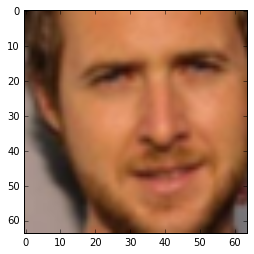

In [4]:
test_x = np.array([misc.imresize(img,(height,width)) for img,label in testset])
test_y = np.array([label for img,label in testset.imgs])
test_y = np.identity(len(testset.classes))[test_y]
for i in xrange(3):
    plt.imshow(test_x[i])

In [5]:
test_x.shape, test_y.shape

((332, 64, 64, 3), (332, 50))

In [6]:
batch_size = 32
epochs = 100

n_input = height * width
n_classes = len(testset.classes) # total classes

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

def next_batch(num, data, labels):
    idx = np.arange(0 , len(trainset)/10*10)
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [8]:
sess = tf.Session()
sess.as_default()

In [9]:
# Graph Input
x = tf.placeholder(tf.float32, [None, height,width,3], name="input_features")
y = tf.placeholder(tf.float32, [None, n_classes], name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# layer 1
W_conv1 = weight_variable([3,3,3,64])
b_conv1 = bias_variable([64])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name="h_conv1")
h_pool1 = max_pool_2x2(h_conv1)

# layer 2
W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name="h_conv2")
h_pool2 = max_pool_2x2(h_conv2)

# layer 3
W_conv3 = weight_variable([3,3,128,256])
b_conv3 = bias_variable([256])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, name="h_conv3")
h_pool3 = max_pool_2x2(h_conv3)

# layer 4
# W_conv4 = weight_variable([3,3,256,512])
# b_conv4 = bias_variable([512])

# h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4, name="h_conv4")
# h_pool4 = max_pool_2x2(h_conv4)

# fully connected layer 1
newHeight = height/8
newWidth = width/8
W_fc1 = weight_variable([newHeight*newWidth*256,1024])
b_fc1 = bias_variable([1024])

h_pool4_flat = tf.reshape(h_pool3, [-1, newHeight*newWidth*256], name="flattened_pool_layer")
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat,W_fc1) + b_fc1, name="h_fc1")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")

# fully connected layer 2
W_fc2 = weight_variable([1024,n_classes])
b_fc2 = bias_variable([n_classes])
y_conv = tf.matmul(h_fc1_drop ,W_fc2) + b_fc2

In [10]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv), name="cross_entropy")
train_step = tf.train.AdamOptimizer(0.1,name="optimizer").minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name="accuracy")

sess.run(tf.global_variables_initializer())

In [11]:
saver = tf.train.Saver()
saver.restore(sess, "saved models/model.ckpt")

INFO:tensorflow:Restoring parameters from saved models/model.ckpt


In [12]:
test_accuracy = accuracy.eval(feed_dict={x: test_x, y: test_y, keep_prob: 1.0}, session=sess)
print 'test accuracy %g' % test_accuracy

test accuracy 0.0240964


In [ ]:
errors =  test_x[map(lambda x: not x, correct_prediction.eval(feed_dict={x: test_x, y: test_y, keep_prob: 1.0}, session=sess))]
y_conv

<tf.Tensor 'add_4:0' shape=(?, 50) dtype=float32>

In [ ]:
print len(errors)
plt.figure(figsize=(10,10))
columns = 5
for i, image in enumerate(errors):
    plt.subplot(len(errors) / 10 + 1, 10, i + 1)
    plt.imshow(image)

324
